The observed mean difference 0.26533359707019444 is statistically significant.
The observed mean difference is at the 99.90 percentile of the distribution.


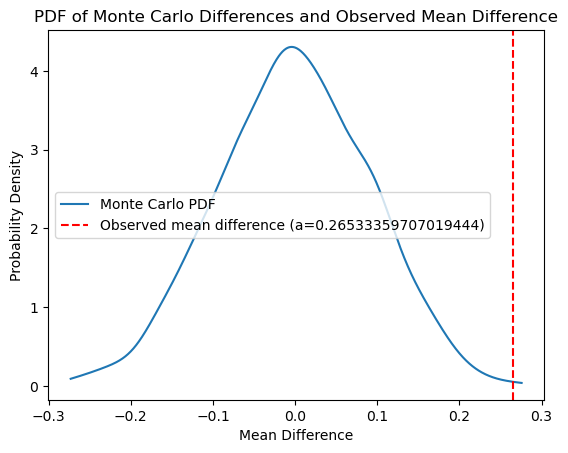

In [1]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt


def equalize_lengths(high, low):
    """Adjusts the lengths of high and low time series to be equal by randomly subsampling the longer one."""
    len_high = high.shape[0]
    len_low = low.shape[0]
    
    if len_high > len_low:
        # Randomly sample from high to match the length of low
        high = high[np.random.choice(len_high, len_low, replace=False), :]
    elif len_low > len_high:
        # Randomly sample from low to match the length of high
        low = low[np.random.choice(len_low, len_high, replace=False), :]
    
    return high, low


# Monte Carlo test function
def monte_carlo_test(high, low, N):
    """
    Perform Monte Carlo test by randomly sampling and calculating differences.
    
    Parameters:
    high : ndarray
        Data representing the "high" group.
    low : ndarray
        Data representing the "low" group.
    N : int
        Number of Monte Carlo iterations.
    
    Returns:
    a : float
        The actual mean difference between high and low.
    aa : ndarray
        Array of random differences generated through Monte Carlo.
    """
    # Concatenate high and low data
    all_data = np.concatenate((high, low), axis=0)
    
    # Actual mean difference
    a = np.nanmean(high) - np.nanmean(low)
    
    # Random sampling and Monte Carlo differences
    aa = np.zeros(N)
    for i in range(N):
        ind_1 = np.random.choice(all_data.shape[0], high.shape[0], replace=False)
        ind_2 = np.setdiff1d(np.arange(all_data.shape[0]), ind_1)
        aa[i] = np.nanmean(all_data[ind_1]) - np.nanmean(all_data[ind_2])
    
    return a, aa

# Significance assessment for single value
def assess_significance_single_value(a, aa, N, signif=0.05):
    """
    Assess whether the single mean difference 'a' is statistically significant.
    
    Parameters:
    a : float
        The actual mean difference between high and low (a single value).
    aa : ndarray
        The array of random differences generated from the Monte Carlo test.
    N : int
        Number of Monte Carlo iterations.
    signif : float
        Significance level (default is 0.05 for 5%).
    
    Returns:
    float
        The value of 'a', or NaN if 'a' is not statistically significant.
    """
    # Check if the observed difference is negative or positive
    if a < 0:
        indexes = np.where(aa > a)[0]
        perc = len(indexes) / N
    else:
        indexes = np.where(aa < a)[0]
        perc = len(indexes) / N

    # If the percentage is less than or equal to the significance level, return NaN
    if perc <= signif:
        return np.nan
    
    return a

# Calculate location of a in the PDF and KDE
def location_in_pdf(a, aa):
    """
    Derives the location of the original mean difference 'a' within
    the PDF built from the random Monte Carlo differences 'aa'.
    
    Parameters:
    a : float
        The actual mean difference between high and low (a single value).
    aa : ndarray
        The array of random differences generated from the Monte Carlo test.
    
    Returns:
    perc : float
        The percentile of 'a' within the distribution of 'aa'.
    kde : gaussian_kde
        The kernel density estimate (PDF) built from 'aa'.
    """
    kde = gaussian_kde(aa)  # Estimate the PDF using kernel density estimation
    perc = np.sum(aa <= a) / len(aa)  # Calculate the percentile of 'a' in the distribution
    return perc, kde

# Plot the PDF with the location of a
def plot_pdf_with_a(a, aa, kde):
    """
    Plot the PDF built from the random Monte Carlo differences and show the location of 'a'.
    
    Parameters:
    a : float
        The actual mean difference between high and low (a single value).
    aa : ndarray
        The array of random differences generated from the Monte Carlo test.
    kde : gaussian_kde
        The kernel density estimate (PDF) built from 'aa'.
    """
    x_vals = np.linspace(min(aa), max(aa), 1000)
    pdf_vals = kde(x_vals)

    # Plot the PDF
    plt.plot(x_vals, pdf_vals, label='Monte Carlo PDF')
    plt.axvline(x=a, color='r', linestyle='--', label=f'Observed mean difference (a={a})')

    # Add labels and legend
    plt.xlabel('Mean Difference')
    plt.ylabel('Probability Density')
    plt.title('PDF of Monte Carlo Differences and Observed Mean Difference')
    plt.legend()
    plt.show()

# Main script
if __name__ == "__main__":
    # Example data: two random sets representing high and low
    high = np.random.randn(15, 10)  # 15 samples, 10 variables
    low = np.random.randn(15, 10)   # 15 samples, 10 variables

    N = 1000  # Number of Monte Carlo iterations

    # Step 1: Perform Monte Carlo test
    a, aa = monte_carlo_test(high, low, N)

    # Step 2: Assess significance
    signif = 0.05  # 5% significance level
    a_significant = assess_significance_single_value(a, aa, N, signif=signif)

    if np.isnan(a_significant):
        print("The observed mean difference is not statistically significant.")
    else:
        print(f"The observed mean difference {a_significant} is statistically significant.")

    # Step 3: Find the location of 'a' within the PDF
    perc, kde = location_in_pdf(a, aa)
    print(f"The observed mean difference is at the {perc * 100:.2f} percentile of the distribution.")

    # Step 4: Plot the PDF and show the location of 'a'
    plot_pdf_with_a(a, aa, kde)
